In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import sys

import matplotlib.pyplot as plt
from batchflow.opensets import MNIST
from batchflow.models.tf import TFModel
from batchflow import Pipeline, L, F, V, D, B, DatasetIndex, Dataset, ImagesBatch, Config

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
mnist = MNIST(batch_class=ImagesBatch)

Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


In [4]:
decay_d = ('exp', {'learning_rate': 0.001,
                   'decay_steps': 150,
                   'decay_rate': 0.96})

model_config = {'inputs': dict(images={'shape': (28, 28, 1)},
                               masks={'name': 'targets', 'shape': (28, 28, 1)}),
                'initial_block': {'layout': 'cna'*2,
                                  'filters': [6]*2, 'kernel_size': [3]*2,
                                  'inputs': 'images'},
                'body': {'layout': 'nca nca',
                         'filters': [8, 1],
                         'kernel_size': [3, 3]},
                'head': {'layout': 'nca',
                         'filters': 1,
                         'kernel_size': 3},
                'loss': 'mse',
#                 'optimizer': 'Adam',
                'decay': decay_d,
                'train_steps': {'ALL': {'optimizer': 'RMSProp', 'decay': decay_d},
                                'BODY': {'optimizer': 'Adam', 'scope': 'body',
                                         'loss': ('l1', {'targets': 'body_tensor'})},
                                'HEAD': {'optimizer': 'Adagrad', 'scope': 'head', 'decay': decay_d},
                                'CUSTOM': {'optimizer': 'Adam', 'scope': '-initial_block/layer-0'}},
                'head/units': 10
}

data_dict = {'images': B('images'),
             'masks': B('images')}

train_pipeline = (mnist.train.p
                 .init_variable('loss_history', init_on_each_run=list)
                 .init_variable('current_loss')
                 .to_array()
                 .multiply(multiplier=1/255., preserve_type=False)
                 .init_model('dynamic', TFModel, 'conv', config=model_config)
                 .to_array()
                 .train_model('conv', fetches='lossALL', feed_dict=data_dict, 
                              train_mode='ALL',
                              save_to=V('current_loss'))
                 .update_variable('loss_history', 
                                  V('current_loss'), 
                                  mode='a')
                  )

In [6]:
%%time
n_b = train_pipeline.next_batch(256, n_epochs=None)
# n_b = train_pipeline.run(256, n_epochs=2, bar=True)

CPU times: user 1.37 s, sys: 104 ms, total: 1.48 s
Wall time: 528 ms


In [7]:
%%time
train_pipeline.run(batch_size=256, n_epochs=1, bar=True)

100%|█████████▉| 234/235 [02:05<00:00,  1.89it/s]

CPU times: user 5min 40s, sys: 15.3 s, total: 5min 55s
Wall time: 2min 5s


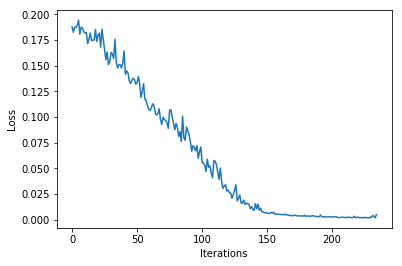

In [8]:
plt.plot(train_pipeline.get_variable("loss_history"))
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

In [ ]:
model = train_pipeline.get_model_by_name('conv')

In [ ]:
batch = train_pipeline.next_batch(10, n_epochs=None)

In [ ]:
train_pipeline.get_variable('result')[0][1].shape

In [ ]:
model.graph.get_operations()

In [ ]:
tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)